In [1]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 26. 01. 2024      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                           
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

In [2]:
depth_slice = 450

### Now working with seal data from Adele (see her email from 04/08/2022, 10:28 AEST)

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ryf = '01deg_jra55v13_ryf9091'
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-120, -50)
lat_slice  = slice(-75.5,-60)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(ryf,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(ryf,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

open saved seal data

In [5]:
%%time
base_seal = '/g/data/v45/akm157/data/meop_seal_data/Australia/DATA_ncARGO_interp/'
# outpath = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091/seal_data_comparison/WAP_MEOP_profiles_interpolated.nc'
outpath = '/g/data/e14/mv7494/seal_data_comparison/' + 'WAP_seal_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-01.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
meop_temp = profile_data.meop_temp
meop_salt = profile_data.meop_salt
date = profile_data.date

CPU times: user 303 ms, sys: 129 ms, total: 431 ms
Wall time: 546 ms


In [6]:
meop_temp

<xarray.DataArray 'meop_temp' (profile_number: 22312)>
array([-0.830861, -0.917594, -0.903895, ...,       nan,       nan,       nan])
Coordinates:
  * profile_number  (profile_number) int64 0 1 2 3 4 ... 22308 22309 22310 22311

Text(0.5, 0, 'Longitude')

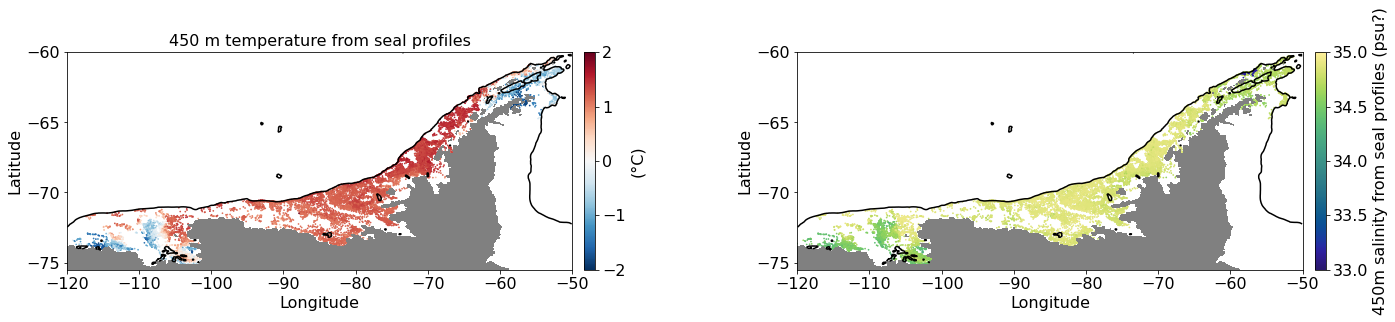

In [7]:
# plot unbinned data:
fontsize = 16
plt.figure(figsize=(24,4))
plt.subplot(1,2,1)
sc = plt.scatter(lon_obs,lat_obs,c=meop_temp,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title(str(depth_slice) +' m temperature from seal profiles', fontsize=fontsize)

import cmocean # salinity colour bar
plt.subplot(1,2,2)
sc = plt.scatter(lon_obs,lat_obs,c=meop_salt,s=.5,cmap=cmocean.cm.haline,vmin=33,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity from seal profiles (psu?)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

## Bin seal data into lat/lon bins:
Redo this step, but first delete any obs profiles where model profiles are nan.

In [8]:
### load data for this year:
start_time='2150-01-01'
end_time='2159-12-31'

temp_ryf = cc.querying.getvar(ryf,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_ryf = temp_ryf.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')                          
temp_ryf = temp_ryf.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_ryf = temp_ryf.load()

In [9]:
# for comparing seal data to IAF:
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2005-02-01'
end_time='2015-10-31'

temp_cycle2 = cc.querying.getvar(cycle2,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle2 = temp_cycle2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle2 = temp_cycle2.load()

temp_cycle3 = cc.querying.getvar(cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle3 = temp_cycle3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle3 = temp_cycle3.load()

salt_cycle2 = cc.querying.getvar(cycle2,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_cycle2 = salt_cycle2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
salt_cycle2 = salt_cycle2.load()

salt_cycle3 = cc.querying.getvar(cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_cycle3 = salt_cycle3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
salt_cycle3 = salt_cycle3.load()

### same for the ACCESS-OM2-1 model

In [10]:
# for comparing seal data to IAF:
cycle5 = '1deg_jra55_iaf_omip2_cycle5'
cycle6 = '1deg_jra55_iaf_omip2_cycle6'

start_time='2005-02-01'
end_time='2015-10-31'

temp_cycle5 = cc.querying.getvar(cycle5,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle5 = temp_cycle5.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

temp_cycle6 = cc.querying.getvar(cycle6,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle6 = temp_cycle6.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

salt_cycle5 = cc.querying.getvar(cycle5,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_cycle5 = salt_cycle5.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

salt_cycle6 = cc.querying.getvar(cycle6,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_cycle6 = salt_cycle6.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

In [11]:
xt_ocean = temp_ryf.xt_ocean
yt_ocean = temp_ryf.yt_ocean
st_ocean = temp_ryf.st_ocean

## Select out model data from same months and locations as seal profiles:
Repeat this to find closest _non-land_ model grid point.

In [13]:
%%time
nprofiles = len(meop_temp)
model_temp_profiles = np.zeros((nprofiles))
model_salt_profiles = np.zeros((nprofiles))
model_lat_profiles = np.zeros(nprofiles)
model_lon_profiles = np.zeros(nprofiles)

# find corresponding model profiles:
for profile in range(nprofiles):
    # skip iteration if file already exists
    if os.path.isfile('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-1_cycle6.nc') == True:
        print('---------------------------------------------------------')
        print('WAP_model_profiles.nc already exists, skipping iterations')
        print('---------------------------------------------------------')
    break
   
    if profile%2000 == 0:
        print('profile '+str(profile)+'/'+str(nprofiles))
    profile_month = date[profile].dt.month.values
    
    # for RYF:
    #model_temp_profiles[profile] = temp_ryf.sel(month=profile_month).sel(xt_ocean=lon_obs[profile],method='nearest')\
    #    .sel(yt_ocean=lat_obs[profile],method='nearest')
    
    ## for IAF:
    profile_year = date[profile].dt.year.values
    start_date = str(profile_year)+'-'+str(profile_month)
    end_date = str(profile_year)+'-'+str(profile_month)
    model_temp_profiles[profile] = temp_cycle6.sel(time=slice(start_date,end_date)).sel(xt_ocean=lon_obs[profile],method='nearest')\
        .sel(yt_ocean=lat_obs[profile],method='nearest')
    model_salt_profiles[profile] = salt_cycle6.sel(time=slice(start_date,end_date)).sel(xt_ocean=lon_obs[profile],method='nearest')\
        .sel(yt_ocean=lat_obs[profile],method='nearest')
    ## end for IAF
    
    

    # check if it has selected a land point:
    '''if np.isnan(model_temp_profiles[profile]):
        # IAF
        temp_slice = temp_cycle2.sel(time=slice(start_date,end_date)).squeeze()
        # RYF
        #temp_slice = temp_ryf.sel(month=profile_month).squeeze()
        # fill in nans once back in y direction, once back in x direction then forwards once in both directions:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        # repeat:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        model_temp_profiles[profile] = temp_slice.sel(xt_ocean=lon_obs[profile],method='nearest')\
            .sel(yt_ocean=lat_obs[profile],method='nearest')
        # This expands everything in  at least 2 grid points (i.e. ~ 10 km). 
        # If there is no matching grid point after that, we will nan the model profile later to match.'''
    
    model_lon_profiles[profile] = xt_ocean.sel(xt_ocean=lon_obs[profile],method='nearest')
    model_lat_profiles[profile] = yt_ocean.sel(yt_ocean=lat_obs[profile],method='nearest')

# save data:
model_temp_profiles = xr.DataArray(model_temp_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'model profiles')
model_salt_profiles = xr.DataArray(model_salt_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'model profiles')
model_lon_profiles = xr.DataArray(model_lon_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of model profiles')
model_lat_profiles = xr.DataArray(model_lat_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of model profiles')

# save data set if it not already exists
if os.path.isfile('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-1_cycle6.nc') == False:
    ds = xr.Dataset({'model_temp_profiles': model_temp_profiles,'model_lon_profiles':model_lon_profiles,'model_lat_profiles':model_lat_profiles,
                     'model_salt_profiles': model_salt_profiles,'model_lon_profiles':model_lon_profiles,'model_lat_profiles':model_lat_profiles})
    ds.to_netcdf('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-1_cycle6.nc') # save into my own folder
# Wall time: 1min 42s

---------------------------------------------------------
WAP_model_profiles.nc already exists, skipping iterations
---------------------------------------------------------
CPU times: user 7.54 ms, sys: 1.06 ms, total: 8.59 ms
Wall time: 6.21 ms


In [14]:
# open saved model profiles:
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
# outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles.nc'
# profile_data = xr.open_dataset(outpath)
# lat_model = profile_data.model_lat_profiles
# lon_model = profile_data.model_lon_profiles
# ryf_temp = profile_data.model_temp_profiles
# ryf_temp = ryf_temp.load()

# outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles.nc'
outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-01_cycle3.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle3_temp = profile_data.model_temp_profiles; cycle3_temp = cycle3_temp.load()
cycle3_salt = profile_data.model_salt_profiles; cycle3_salt = cycle3_salt.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-01_cycle2.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle2_temp = profile_data.model_temp_profiles; cycle2_temp = cycle2_temp.load()
cycle2_salt = profile_data.model_salt_profiles; cycle2_salt = cycle2_salt.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-1_cycle5.nc'
profile_data = xr.open_dataset(outpath)
lat_model_1deg = profile_data.model_lat_profiles
lon_model_1deg = profile_data.model_lon_profiles
cycle5_temp = profile_data.model_temp_profiles.load(); cycle5_salt = profile_data.model_salt_profiles.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_'+str(depth_slice)+'m_depth_ACCESS-OM2-1_cycle6.nc'
profile_data = xr.open_dataset(outpath)
lat_model_1deg = profile_data.model_lat_profiles
lon_model_1deg = profile_data.model_lon_profiles
cycle6_temp = profile_data.model_temp_profiles.load(); cycle6_salt = profile_data.model_salt_profiles.load()

# need to assign lat/lon coords for binning:
#iaf_temp = iaf_temp.assign_coords({'lon':lon_model,'lat':lat_model})

CPU times: user 3.44 s, sys: 649 ms, total: 4.08 s
Wall time: 3.52 s


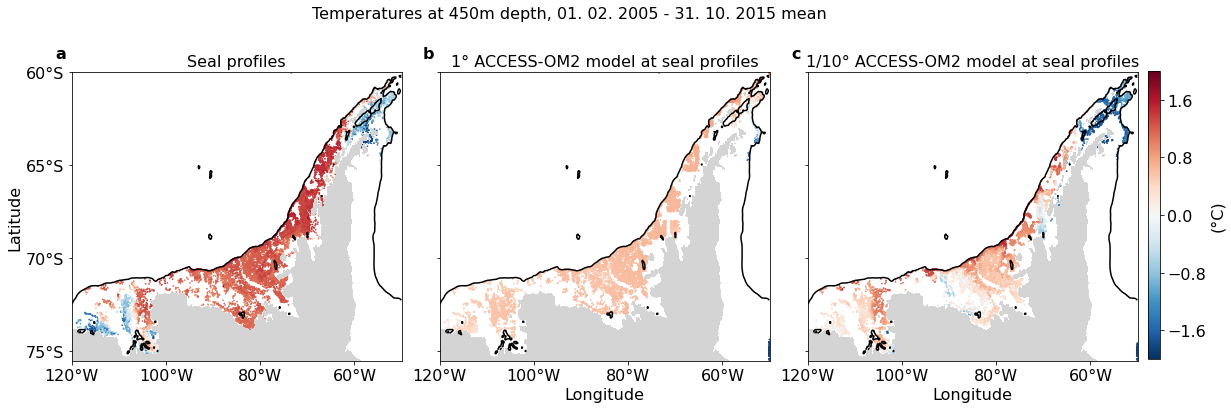

In [15]:
%%time
fontsize = 16

# Take mean of cycle2 and cycle3:
iaf_temp = (cycle3_temp+cycle2_temp)/2
iaf_temp_1deg = (cycle5_temp+cycle6_temp)/2

fig = plt.figure(figsize=(16,10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3) 
       
# first panel with seal OBS data
# -------------------------------------------------------------------------------------------------- #
for f in [0,1,2]:
    if f == 0:
        panel = gs[0,0]; lon = lon_obs; lat = lat_obs; data = meop_temp; scale = 1; title_str = 'Seal profiles'
    if f == 1:
        panel = gs[0,1]; lon = lon_model; lat = lat_model; data = (iaf_temp_1deg); scale = 1; title_str = '1° ACCESS-OM2 model at seal profiles'        
    if f == 2:
        panel = gs[0,2]; lon = lon_model; lat = lat_model; data = (iaf_temp); scale = 1; title_str = '1/10° ACCESS-OM2 model at seal profiles'         

    ax1 = plt.subplot(panel)    

    ascii_nrs = [0,1,2,0,3,4]
    ax1.text(-.05, 1.05, string.ascii_lowercase[ascii_nrs[f]], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    sc = plt.scatter(lon,lat,c=data,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
    cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k', linewidth=1.25)
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='#d4d4d4') # light grey land
    plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0],linewidth='4',colors='black') # light grey land

    

    plt.xlim(-120,-50); plt.ylim(-75.5,-60)
    plt.tick_params(labelsize=fontsize)
    # replace lables with °W/°S labels
    labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['120°W', '100°W', '80°W', '60°W']) # replace labels in °N with across-shelf distance
    plt.locator_params(axis='y', nbins=4) # only 4 y-axis ticks
    labels = [item.get_text() for item in ax1.get_yticklabels()]; ax1.set_yticklabels(['', '75°S', '70°S', '65°S', '60°S'])

    if f in [4,5]:
        # adding the region rectangles for AS and BS
        AS = [-127,-101,-77,-70]; BS = [-101,-80,-77,-70]; PR = [-80,-63, -74, -63]
        # # drawing the AS and BS rectangles
        for r in range(4): # loop through the four sides of the rectangle
            if r == 0: lons = [AS[0],AS[1]]; lats = [AS[2], AS[2]] # bottom
            if r == 1: lons = [AS[0],AS[1]]; lats = [AS[3], AS[3]] # top
            if r == 2: lons = [AS[0],AS[0]]; lats = [AS[2], AS[3]] # left
            if r == 3: lons = [AS[1],AS[1]]; lats = [AS[2], AS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        for r in range(3): # loop through the four sides of the rectangle
            if r == 0: lons = [BS[0],BS[1]]; lats = [BS[2], BS[2]] # bottom
            if r == 1: lons = [BS[0],BS[1]]; lats = [BS[3], BS[3]] # top
            if r == 2: lons = [BS[1],BS[1]]; lats = [BS[2], BS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        # adding text label
        ax1.text( -119, -75, 'AS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -75, 'BS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    plt.title(title_str, fontsize=fontsize) # add title

    if f in [0]: plt.ylabel('Latitude',fontsize=fontsize); plt.xlabel(None)
    if f in [1,2,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None) 
    # if f in [1,2]:   ax1.set_xticklabels([]); ax1.set(xlabel=None) # remove superfluous labels
    plt.xlabel('Longitude', fontsize=fontsize)

    if f in [0]: 
        plt.xlabel(None)            
        # add colour bar 
        # cax = fig.add_axes([.07, .4, .25, .02]) # for horizontal colour bar
        #                 ([x0, y0, width, height])
        cax = fig.add_axes([1, .49,   .01,     .4]) # for vertical colour bar

        cb = plt.colorbar(sc, cax = cax, shrink=1, orientation='vertical'); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        # cb.add_lines(p11) # add contours to colour bar
        
    if f in [4,5]:
        # Calculate the bias that goes into the AS and BS regions
        diff = data # difference between OBS and model
        
        # mask out all Amundsen Sea profiles, fill rest with nan and  replace all non-nan values with the 1 index
        AS_profiles = (lon_obs.where((lon_obs > -120) & (lon_obs < -101))).fillna(np.nan); AS_profiles = AS_profiles.where(np.logical_or(AS_profiles.isnull(), xr==0), 1)
        bias_AS = str(np.round((diff*AS_profiles).mean().values,2)) + '°C'

        BS_profiles = (lon_model.where((lon_model > -101) & (lon_model < -80))).fillna(np.nan); BS_profiles = BS_profiles.where(np.logical_or(BS_profiles.isnull(), xr==0), 1)
        bias_BS = str(np.round((diff*BS_profiles).mean().values,2)) + '°C'

        # add the model bias in the AS and BS into the boxes
        ax1.text( -119, -69.5, bias_AS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -69.5, bias_BS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
        
plt.suptitle('Temperatures at '+str(depth_slice)+'m depth, 01. 02. 2005 - 31. 10. 2015 mean \n', fontsize=fontsize)

# --- saving as 300 dpi .PNG image in specified folder ---------------------------- #
plt.savefig(save + 'Seal_OBS_ACCESS-OM2-1_ACCESS-OM2-01_iaf_comparison', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                 #
            format=None, transparent=False, bbox_inches='tight',                    #
            pad_inches=0.1, metadata=None)                                          #
# --- end of script --------------------------------------------------------------- #
# Wall time: 5.16 s

CPU times: user 3.15 s, sys: 633 ms, total: 3.78 s
Wall time: 3.22 s


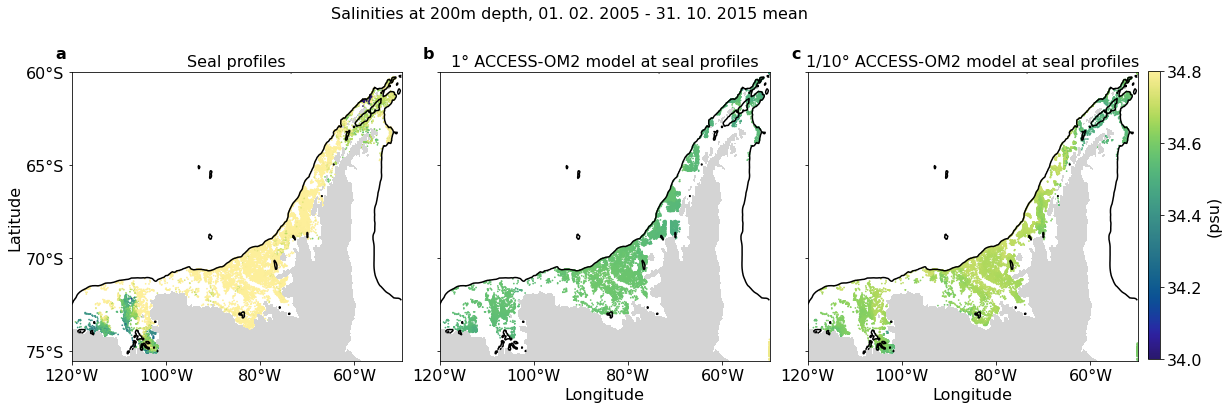

In [21]:
%%time
fontsize = 16

# Take mean of cycle2 and cycle3:
iaf_salt = (cycle3_salt+cycle2_salt)/2
iaf_salt_1deg = (cycle5_salt+cycle6_salt)/2

fig = plt.figure(figsize=(16,10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3) 
       
# first panel with seal OBS data
# -------------------------------------------------------------------------------------------------- #
for f in [0,1,2]:
    if f == 0:
        panel = gs[0,0]; lon = lon_obs; lat = lat_obs; data = meop_salt; scale = 1; title_str = 'Seal profiles'
    if f == 1:
        panel = gs[0,1]; lon = lon_model; lat = lat_model; data = (iaf_salt_1deg); scale = 1; title_str = '1° ACCESS-OM2 model at seal profiles'        
    if f == 2:
        panel = gs[0,2]; lon = lon_model; lat = lat_model; data = (iaf_salt); scale = 1; title_str = '1/10° ACCESS-OM2 model at seal profiles'         
#     if f == 4:
#         panel = gs[1,1]; lon = lon_model; lat = lat_model; data = iaf_temp_1deg-meop_temp; scale = 1; title_str = 'ACCESS-OM2-1 \n difference to seal profiles'        
#     if f == 5:
#         panel = gs[1,2]; lon = lon_model; lat = lat_model; data = iaf_temp-meop_temp; scale = 1; title_str = 'ACCESS-OM2-01 \n difference to seal profiles'     
        
        
    ax1 = plt.subplot(panel)    

    ascii_nrs = [0,1,2,0,3,4]
    ax1.text(-.05, 1.05, string.ascii_lowercase[ascii_nrs[f]], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    sc = plt.scatter(lon,lat,c=data,s=.5,cmap=cmocean.cm.haline,vmin=34,vmax=34.8)
    cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k', linewidth=1.25)
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='#d4d4d4') # light grey land
    plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0],linewidth='4',colors='black') # light grey land

    

    plt.xlim(-120,-50); plt.ylim(-75.5,-60)
    plt.tick_params(labelsize=fontsize)
    # replace lables with °W/°S labels
    labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['120°W', '100°W', '80°W', '60°W']) # replace labels in °N with across-shelf distance
    plt.locator_params(axis='y', nbins=4) # only 4 y-axis ticks
    labels = [item.get_text() for item in ax1.get_yticklabels()]; ax1.set_yticklabels(['', '75°S', '70°S', '65°S', '60°S'])

    if f in [4,5]:
        # adding the region rectangles for AS and BS
        AS = [-127,-101,-77,-70]; BS = [-101,-80,-77,-70]; PR = [-80,-63, -74, -63]
        # # drawing the AS and BS rectangles
        for r in range(4): # loop through the four sides of the rectangle
            if r == 0: lons = [AS[0],AS[1]]; lats = [AS[2], AS[2]] # bottom
            if r == 1: lons = [AS[0],AS[1]]; lats = [AS[3], AS[3]] # top
            if r == 2: lons = [AS[0],AS[0]]; lats = [AS[2], AS[3]] # left
            if r == 3: lons = [AS[1],AS[1]]; lats = [AS[2], AS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        for r in range(3): # loop through the four sides of the rectangle
            if r == 0: lons = [BS[0],BS[1]]; lats = [BS[2], BS[2]] # bottom
            if r == 1: lons = [BS[0],BS[1]]; lats = [BS[3], BS[3]] # top
            if r == 2: lons = [BS[1],BS[1]]; lats = [BS[2], BS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        # adding text label
        ax1.text( -119, -75, 'AS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -75, 'BS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    plt.title(title_str, fontsize=fontsize) # add title

    if f in [0]: plt.ylabel('Latitude',fontsize=fontsize); plt.xlabel(None)
    if f in [1,2,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None) 
    # if f in [1,2]:   ax1.set_xticklabels([]); ax1.set(xlabel=None) # remove superfluous labels
    plt.xlabel('Longitude', fontsize=fontsize)

    if f in [0]: 
        plt.xlabel(None)            
        # add colour bar 
        # cax = fig.add_axes([.07, .4, .25, .02]) # for horizontal colour bar
        #                 ([x0, y0, width, height])
        cax = fig.add_axes([1, .49,   .01,     .4]) # for vertical colour bar

        cb = plt.colorbar(sc, cax = cax, shrink=1, orientation='vertical'); 
        cb_txt = cb.set_label(label='(psu)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        # cb.add_lines(p11) # add contours to colour bar
        
    if f in [4,5]:
        # Calculate the bias that goes into the AS and BS regions
        diff = data # difference between OBS and model
        
        # mask out all Amundsen Sea profiles, fill rest with nan and  replace all non-nan values with the 1 index
        AS_profiles = (lon_obs.where((lon_obs > -120) & (lon_obs < -101))).fillna(np.nan); AS_profiles = AS_profiles.where(np.logical_or(AS_profiles.isnull(), xr==0), 1)
        bias_AS = str(np.round((diff*AS_profiles).mean().values,2)) + '°C'

        BS_profiles = (lon_model.where((lon_model > -101) & (lon_model < -80))).fillna(np.nan); BS_profiles = BS_profiles.where(np.logical_or(BS_profiles.isnull(), xr==0), 1)
        bias_BS = str(np.round((diff*BS_profiles).mean().values,2)) + '°C'

        # add the model bias in the AS and BS into the boxes
        ax1.text( -119, -69.5, bias_AS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -69.5, bias_BS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
        
plt.suptitle('Salinities at '+str(depth_slice)+'m depth, 01. 02. 2005 - 31. 10. 2015 mean \n', fontsize=fontsize)

# --- saving as 300 dpi .PNG image in specified folder ---------------------------- #
plt.savefig(save + 'Seal_OBS_ACCESS-OM2-1_ACCESS-OM2-01_iaf_comparison_salt', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                 #
            format=None, transparent=False, bbox_inches='tight',                    #
            pad_inches=0.1, metadata=None)                                          #
# --- end of script --------------------------------------------------------------- #
# Wall time: 5.16 s

### Saving the data to recreate the figure

In [17]:
meop_temp # Seal OBS
# iaf_temp_1deg # 1° ACCESS-OM2 IAF model run
# iaf_temp # 1/10° ACCESS-OM2 IAF model run
# meop_temp

<xarray.DataArray 'meop_temp' (profile_number: 22312)>
array([-0.830861, -0.917594, -0.903895, ...,       nan,       nan,       nan])
Coordinates:
  * profile_number  (profile_number) int64 0 1 2 3 4 ... 22308 22309 22310 22311

In [19]:
meop_temp['lon_obs'] = lon_obs
meop_temp['lat_obs'] = lat_obs
meop_temp.attrs = {'Units': '[°C]', 
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-06-15', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
meop_temp.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS13a_MEOP_Data_Temp.nc')
meop_salt['lon_obs'] = lon_obs
meop_salt['lat_obs'] = lat_obs
meop_salt.attrs = {'Units': '[psu]', 
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-11-28', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
meop_salt.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS14a_MEOP_Data_Salt.nc')

iaf_temp_1deg['lon_model'] = lon_model
iaf_temp_1deg['lat_model'] = lat_model
iaf_temp_1deg.attrs = {'Model': '1° ACCESS-OM2 model',
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Units': '[°C]', 
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-06-15', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_temp_1deg.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS13c_ACCESS-OM2-1_Data_Temp.nc')

iaf_salt_1deg['lon_model'] = lon_model
iaf_salt_1deg['lat_model'] = lat_model
iaf_salt_1deg.attrs = {'Model': '1° ACCESS-OM2 model',
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Units': '[psu]', 
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-11-28', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_salt_1deg.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS14c_ACCESS-OM2-1_Data_Salt.nc')

iaf_temp['lon_model'] = lon_model
iaf_temp['lat_model'] = lat_model
iaf_temp.attrs = {'Model': '1/10° ACCESS-OM2 model',
                  'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                  'Units': '[°C]', 
                  'Author': 'Maurice F. Huguenin', 
                  'Created': '2023-06-15', 
                  'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                  'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_temp.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS13b_ACCESS-OM2-1_Data_Temp.nc')
iaf_salt['lon_model'] = lon_model
iaf_salt['lat_model'] = lat_model
iaf_salt.attrs = {'Model': '1/10° ACCESS-OM2 model',
                  'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                  'Units': '[psu]', 
                  'Author': 'Maurice F. Huguenin', 
                  'Created': '2023-11-28', 
                  'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                  'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_salt.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS14b_ACCESS-OM2-1_Data_Salt.nc')

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #